In [1]:
import numpy as np
import pandas as pd
import os
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp5cd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp5cd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
input_data = pd.read_csv('TWEETS.csv')
input_data = input_data[['label','tweet']]
#scan the dataframe
input_data.head()

,label,tweet
0,positive,@VirginAmerica nervous about my flight from DC...
1,positive,@VirginAmerica cool picture of another VirginA...
2,positive,@VirginAmerica Keep up the great work :)
3,positive,@VirginAmerica my goodness your people @love f...
4,positive,@VirginAmerica Thanks for a great flight from ...


In [3]:
input_data.shape

(14438, 2)

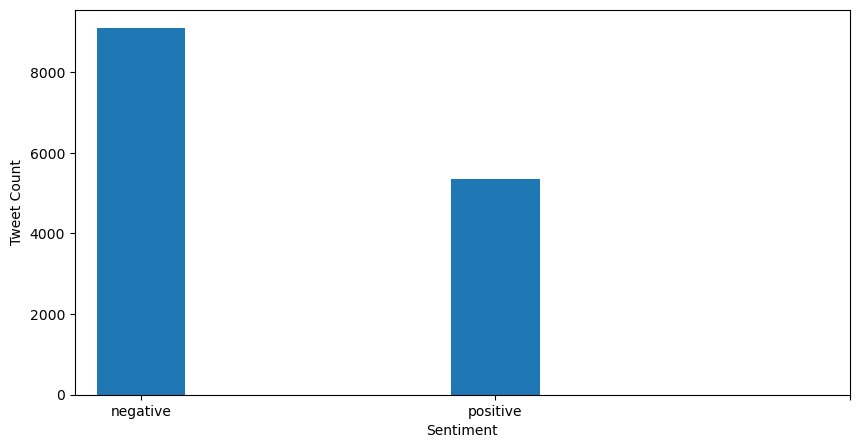

In [4]:
label_dist = input_data['label'].value_counts().to_dict()
fig = plt.figure(figsize = (10, 5))
ax = plt.bar(label_dist.keys(), label_dist.values(), width=0.25)
plt.xticks([0,1,2])
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.show()

In [5]:
len(input_data['tweet'])-len(input_data['tweet'].drop_duplicates())

212

In [6]:
input_data=input_data.drop_duplicates(subset='tweet', keep="last")
input_data.shape

(14226, 2)

In [7]:
input_data['length']=input_data['tweet'].apply(lambda x: len(x.split(' ')))

In [8]:
input_data.sample(10)

,label,tweet,length
1696,negative,@united you should spend all of the money you ...,23
3797,negative,@united My wife has been on the phone several ...,17
6920,negative,:( RT @JetBlue: Our fleet's on fleek. http://t...,8
6750,negative,@JetBlue @MrJustyn I heard companies were stud...,18
1554,negative,@united thanks for having no one to pilot my l...,26
2879,negative,@united then send your Jeff Smisek on a trip w...,27
5170,positive,@southwestair your attendants at the ATL airpo...,18
6889,positive,@JetBlue with 3 kids and 11 days 340 + doesn't...,16
7224,positive,@JetBlue woof I'm on the red cArpet http://t.c...,8
2969,negative,@united I did they did not. I did submit a co...,30


In [9]:
print(round(input_data[input_data['label']=='negative']['length'].mean()))
print(round(input_data[input_data['label']=='positive']['length'].mean()))

20
14


<Axes: ylabel='Frequency'>

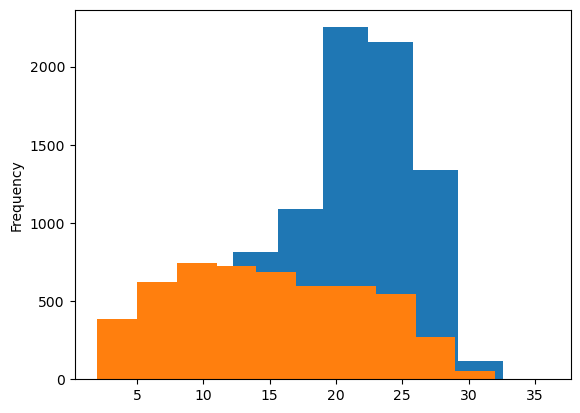

In [10]:
input_data[input_data['label']=='negative']['length'].plot.hist(bins=10)
input_data[input_data['label']=='positive']['length'].plot.hist(bins=10)

In [11]:
input_data["tweet_new"]=input_data["tweet"].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))

In [12]:
def text_clean(tweet):
    #lowercase the tweet
    tweet=tweet.lower()
    #remove punctuation 
    tweet = re.sub('[()!?]', ' ', tweet)
    tweet = re.sub('\[.*?\]',' ', tweet)
    #remove non alphanumeric occurences
    tweet = re.sub("[^a-z0-9]"," ", tweet)
    #remove the @mention
    tweet = re.sub("@[A-Za-z0-9_]+","", tweet)
    #remove the hastags
    tweet = re.sub("#[A-Za-z0-9_]+","", tweet)
    #remove any links 
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"www.\S+", "", tweet)
    return tweet

In [13]:
input_data['clean_tweet'] = input_data['tweet_new'].apply(text_clean)

In [14]:
input_data[['tweet','clean_tweet']].sample(10)

,tweet,clean_tweet
10889,@USAirways please secure the 'footrest' shelf'...,usairways please secure footrest shelf bus...
9602,@USAirways what is wrong with you guys and you...,usairways wrong guys inability get planes phi...
2422,@united y not? You're the reason we're in Hous...,united not you re reason we re houston nyc t...
9254,@USAirways nice try at the gate making travele...,usairways nice try gate making traveler trave...
2196,@united yes 1427 Cancelled Flightled. Moved to...,united yes 1427 cancelled flightled moved 33...
8637,@jetblue any idea where the plane for flight 6...,jetblue idea plane flight 672 coming from i ...
12560,@AmericanAir - cluster continues-still on conn...,americanair cluster continues still connect...
400,@united dm these nuts,united dm nuts
7353,@JetBlue BOS. Everything current now. Thanks f...,jetblue bos everything current now thanks f...
12771,@AmericanAir What's with your baggage handlers...,americanair what s baggage handlers calling d...


In [15]:
input_data['new_length']=input_data['clean_tweet'].apply(lambda x: len(x.split(" ")))

In [16]:
print(round(input_data[input_data['label']=='negative']['new_length'].mean()))
print(round(input_data[input_data['label']=='positive']['new_length'].mean()))


18
15


<Axes: ylabel='Frequency'>

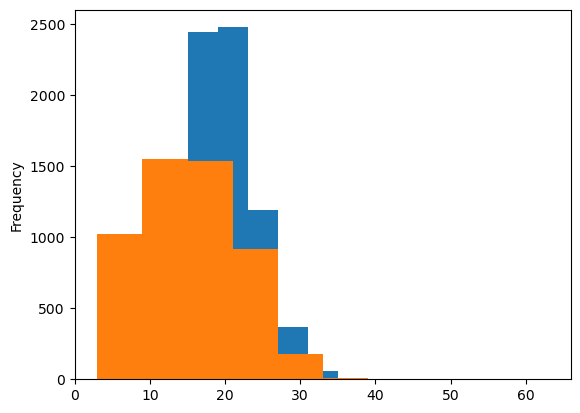

In [17]:
input_data[input_data['label']=='negative']['new_length'].plot.hist(bins=10)
input_data[input_data['label']=='positive']['new_length'].plot.hist(bins=10)


In [18]:
top_words = 20
#tokenize the tweets into individual tokens
words = nltk.tokenize.word_tokenize(input_data['clean_tweet'].str.cat(sep=' '))
#list of redundant words to be not considered in the frequency count
dropwords=['to','i','the','a','you','for','on','and','t','is','in','it','of','me','my','that','can','have','not','s',
          'co','http','are','was','with','at','your','this','we','be','2','get','from','an','do','so','up','m']
filter_words = [word for word in words if word not in dropwords]

In [19]:
#Use the FreqDist function from nltk for freq count
word_freq = nltk.FreqDist(filter_words)
#create the dataframe for top occuring words
wordfreq_df = pd.DataFrame(word_freq.most_common(top_words),
                    columns=['Word', 'Frequency'])

In [20]:
print(wordfreq_df)

            Word  Frequency
0         united       4146
1         flight       3829
2      usairways       3038
3    americanair       2798
4   southwestair       2447
5        jetblue       2382
6         thanks       1035
7      cancelled       1031
8        service        948
9           help        856
10          time        773
11      customer        741
12           amp        667
13         hours        664
14            us        662
15          hold        636
16         plane        630
17       flights        630
18         still        576
19         thank        571


In [21]:
X_train, X_test, y_train, y_test = train_test_split(input_data["clean_tweet"],
                                                    input_data["label"],test_size=0.3,
                                                    stratify=input_data['label'])

In [22]:
print(X_train.shape[0],X_test.shape[0])

9958 4268


In [23]:
print(y_train.value_counts())

label
negative    6301
positive    3657
Name: count, dtype: int64


In [24]:
print(y_test.value_counts())

label
negative    2701
positive    1567
Name: count, dtype: int64


In [25]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [26]:
lr = LogisticRegression()
lr.fit(X_train_vec,y_train)
print(confusion_matrix(lr.predict(X_test_vec),y_test))
print(classification_report(lr.predict(X_test_vec),y_test))

[[2353  415]
 [ 348 1152]]
              precision    recall  f1-score   support

    negative       0.87      0.85      0.86      2768
    positive       0.74      0.77      0.75      1500

    accuracy                           0.82      4268
   macro avg       0.80      0.81      0.81      4268
weighted avg       0.82      0.82      0.82      4268



C:\Users\hp5cd\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
#train and evaluate the multinominal Naive Baysian Classifier model 
MNB = MultinomialNB()
MNB.fit(X_train_vec,y_train)
print(confusion_matrix(MNB.predict(X_test_vec),y_test))
print(classification_report(MNB.predict(X_test_vec),y_test))

[[2513  589]
 [ 188  978]]
              precision    recall  f1-score   support

    negative       0.93      0.81      0.87      3102
    positive       0.62      0.84      0.72      1166

    accuracy                           0.82      4268
   macro avg       0.78      0.82      0.79      4268
weighted avg       0.85      0.82      0.83      4268



In [29]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_vec,y_train)
print(confusion_matrix(rf.predict(X_test_vec),y_test))
print(classification_report(rf.predict(X_test_vec),y_test))


[[2372  516]
 [ 329 1051]]
              precision    recall  f1-score   support

    negative       0.88      0.82      0.85      2888
    positive       0.67      0.76      0.71      1380

    accuracy                           0.80      4268
   macro avg       0.77      0.79      0.78      4268
weighted avg       0.81      0.80      0.80      4268



In [30]:
vectorizertfidf = TfidfVectorizer(use_idf=True)
X_train_tfvec = vectorizertfidf.fit_transform(X_train)
X_test_tfvec = vectorizertfidf.transform(X_test)
lr = LogisticRegression()
lr.fit(X_train_tfvec,y_train)
#evaluate the performance of logistic model on test data 
print(confusion_matrix(lr.predict(X_test_tfvec),y_test))
print(classification_report(lr.predict(X_test_tfvec),y_test))


[[2457  525]
 [ 244 1042]]
              precision    recall  f1-score   support

    negative       0.91      0.82      0.86      2982
    positive       0.66      0.81      0.73      1286

    accuracy                           0.82      4268
   macro avg       0.79      0.82      0.80      4268
weighted avg       0.84      0.82      0.82      4268



In [31]:
rf = RandomForestClassifier(n_estimators=200, random_state=0)
rf.fit(X_train_tfvec,y_train)
print(confusion_matrix(rf.predict(X_test_tfvec),y_test))
print(classification_report(rf.predict(X_test_tfvec),y_test))

[[2474  598]
 [ 227  969]]
              precision    recall  f1-score   support

    negative       0.92      0.81      0.86      3072
    positive       0.62      0.81      0.70      1196

    accuracy                           0.81      4268
   macro avg       0.77      0.81      0.78      4268
weighted avg       0.83      0.81      0.81      4268



In [32]:
MNB =  MultinomialNB()
MNB.fit(X_train_tfvec,y_train)
print(confusion_matrix(MNB.predict(X_test_tfvec),y_test))
print(classification_report(MNB.predict(X_test_tfvec),y_test))

[[2641  939]
 [  60  628]]
              precision    recall  f1-score   support

    negative       0.98      0.74      0.84      3580
    positive       0.40      0.91      0.56       688

    accuracy                           0.77      4268
   macro avg       0.69      0.83      0.70      4268
weighted avg       0.88      0.77      0.80      4268



In [33]:
SVC = LinearSVC()
SVC.fit(X_train_tfvec,y_train)
print(confusion_matrix(SVC.predict(X_test_tfvec),y_test))
print(classification_report(SVC.predict(X_test_tfvec),y_test))

[[2364  435]
 [ 337 1132]]
              precision    recall  f1-score   support

    negative       0.88      0.84      0.86      2799
    positive       0.72      0.77      0.75      1469

    accuracy                           0.82      4268
   macro avg       0.80      0.81      0.80      4268
weighted avg       0.82      0.82      0.82      4268



C:\Users\hp5cd\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [35]:
test_df=pd.read_csv('test_tweets.csv')

In [36]:
test_df.shape

(202, 2)

In [37]:
test_df.head()

,label,tweet
0,positive,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,positive,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [38]:
test_df["tweet"]=test_df["tweet"].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))

In [39]:
test_df['tweet'] = test_df['tweet'].apply(text_clean)

In [40]:
test_vec = vectorizertfidf.transform(test_df['tweet'])

In [41]:
predictions=lr.predict(test_vec)

In [42]:
print(confusion_matrix(predictions,test_df['label']))
print(classification_report(predictions,test_df['label']))

[[69 19]
 [15 99]]
              precision    recall  f1-score   support

    negative       0.82      0.78      0.80        88
    positive       0.84      0.87      0.85       114

    accuracy                           0.83       202
   macro avg       0.83      0.83      0.83       202
weighted avg       0.83      0.83      0.83       202



In [44]:
test_df['predictions']=predictions
#validate the final test dataframe 
test_df.head(15)

,label,tweet,predictions
0,positive,virginamerica what dhepburn said,negative
1,positive,virginamerica plus added commercials experien...,positive
2,positive,virginamerica i today must mean i need tak...,positive
3,negative,virginamerica really aggressive blast obnoxio...,negative
4,negative,virginamerica really big bad thing,negative
5,negative,virginamerica seriously would pay 30 flight ...,negative
6,positive,virginamerica yes nearly every time i fly vx...,negative
7,positive,virginamerica really missed prime opportunity...,negative
8,positive,virginamerica well i didn t but now i do d,positive
9,positive,virginamerica amazing arrived hour early yo...,positive
